In [ ]:
# installing libraries
# !pip install yellowbrick

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import seaborn as sns  # For enhanced visualization
import datetime  # Duplicate import, consider removing
import warnings  # For handling warnings

# Importing specific modules from scikit-learn
from sklearn.preprocessing import OrdinalEncoder  # For encoding categorical variables
from sklearn.cluster import KMeans  # For KMeans clustering
from sklearn.preprocessing import MinMaxScaler  # For feature scaling
from yellowbrick.cluster import KElbowVisualizer  # For finding optimal K in KMeans
from sklearn.preprocessing import StandardScaler  # For feature scaling
warnings.filterwarnings("ignore")  # Suppressing warnings during runtime

In [ ]:
# Loading the dataset from the specified file path
file_path = '/content/drive/MyDrive/Job Hunt/Customer/RFM segmentation/online_retail_II.xlsx'
data = pd.read_excel(file_path, sheet_name="Year 2010-2011")

# Checking number of samples(rows) and attributes(columns) in the data
data.shape

(541910, 8)

In [ ]:
# Displaying the first few rows of the loaded dataset
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Displaying summary information about the dataset, including data types, missing values,etc.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# Displaying summary statistics for the 'Quantity' and 'Price' columns
data[['Quantity', 'Price']].describe()

,Quantity,Price
count,541910.000000,541910.000000
mean,9.552234,4.611138
std,218.080957,96.759765
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


**There are some negative values as well in this price, we clean that too.**

In [ ]:
# Counting the occurrences of each unique value in the 'Country' column
data['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8558
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

**Most of the customers are from united kingdom and Europe.**

##Data cleaning

In [ ]:
# Finding the number of distinct values in the 'Invoice' and 'Customer ID' columns
data['Invoice'].nunique(), data['Customer ID'].nunique()

(25900, 4372)

**There are 25900 distinct invoices and 4372 distinct customer.**

In [ ]:
# Counting the occurrences of invoices containing 'C'
print(data["Invoice"].str.contains("C", na=False).sum())

# Finding the number of unique invoices containing 'C'
print(data[data["Invoice"].str.contains("C", na=False)]["Invoice"].nunique())

# Removing 'C' from the 'Invoice' column and converting it to string type
data["Invoice"] = data["Invoice"].astype(str).replace('C', '', regex=True)

9288
3836


In [ ]:
# Checking for missing values in the dataset
data.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [ ]:
# Dropping/deleting rows with missing values from the dataset
data.dropna(inplace=True)

# Filtering out rows where Quantity is greater than 0
data = data[data["Quantity"] > 0]

# Filtering out rows where Price is greater than 0
data = data[data["Price"] > 0]

In [ ]:
# Finding the number of unique values in the 'Invoice' and 'Customer ID' columns after filtering
data['Invoice'].nunique(), data['Customer ID'].nunique()

(18532, 4338)

## Customer Segmentation using RFM

- As this dataset is too old, we will calculate reference date for the further calculation of recency.

- Reference date will be the 1 year later date to the last purchase of order in this dataset.

In [ ]:
# Creating a new column 'TotalPrice' by multiplying 'Quantity' and 'Price'
data["TotalPrice"] = data["Quantity"] * data["Price"]

# Finding the last purchase date
last_purchase_date = data['InvoiceDate'].max().date()

# Setting the reference date for RFM analysis as one year after the last purchase
reference_date = last_purchase_date.replace(year=last_purchase_date.year + 1)

# Grouping data by 'Customer ID' and aggregating RFM metrics
data_rfm = data.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max().date()).days,
    "Invoice": lambda x: x.nunique(),
    "TotalPrice": lambda x: x.sum()
})

# Renaming columns for clarity
data_rfm = data_rfm.rename(columns={"InvoiceDate": "recency", "Invoice": "frequency", "TotalPrice": "monetary"})

# Displaying the first few rows of the RFM dataset
data_rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,691,1,77183.60
12347.0,368,7,4310.00
12348.0,441,4,1797.24
12349.0,384,1,1757.55
12350.0,676,1,334.40


In [ ]:
# Creating 'recency_score' based on quantiles (5 bins)
data_rfm["recency_score"] = pd.qcut(data_rfm["recency"], 5, labels=[5, 4, 3, 2, 1])

# Creating 'frequency_score' based on rank (5 bins)
data_rfm["frequency_score"] = pd.qcut(data_rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# Creating 'monetary_score' based on quantiles (5 bins)
data_rfm["monetary_score"] = pd.qcut(data_rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])

# Combining 'recency_score' and 'frequency_score' to get 'rfm_score'
data_rfm["rfm_score"] = data_rfm["recency_score"].astype("str") + data_rfm["frequency_score"].astype("str")

# Displaying the first few rows of the RFM dataset with scores
data_rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
Customer ID,,,,,,,
12346.0,691,1,77183.60,1,1,5,11
12347.0,368,7,4310.00,5,5,5,55
12348.0,441,4,1797.24,2,4,4,24
12349.0,384,1,1757.55,4,1,4,41
12350.0,676,1,334.40,1,1,2,11


In [ ]:
# Defining a segmentation map for RFM scores
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

# Applying the segmentation map to create 'RFM_segment' column
data_rfm['RFM_segment'] = data_rfm['rfm_score'].replace(seg_map, regex=True)

# Resetting the index in-place
data_rfm.reset_index(inplace=True)

# Creating an instance of OrdinalEncoder
encoder = OrdinalEncoder(dtype=int)

# Fitting and transforming the 'RFM_segment' column
data_rfm['RFM_segment_encoded'] = encoder.fit_transform(data_rfm[['RFM_segment']])

# Displaying the updated DataFrame with RFM segment and encoded segment columns
data_rfm.head()

,Customer ID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,RFM_segment,RFM_segment_encoded
0,12346.0,691,1,77183.60,1,1,5,11,hibernating,4
1,12347.0,368,7,4310.00,5,5,5,55,champions,3
2,12348.0,441,4,1797.24,2,4,4,24,at_Risk,1
3,12349.0,384,1,1757.55,4,1,4,41,promising,9
4,12350.0,676,1,334.40,1,1,2,11,hibernating,4


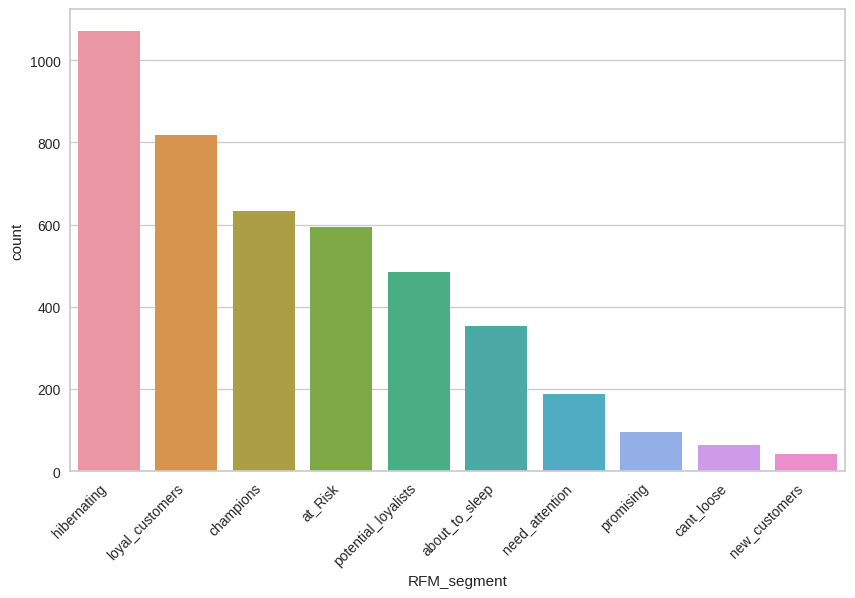

In [ ]:
def countplot(data, x_column, figsize=(10, 6), rotation=45, ha='right'):
    """
    Generate a countplot for the specified column in the given dataset.

    Parameters:
        data (pd.DataFrame): The dataset to be used.
        x_column (str): The column to be plotted on the x-axis.
        figsize (tuple, optional): Figure size (width, height). Default is (10, 6).
        rotation (int, optional): Rotation angle of x-axis labels. Default is 45.
        ha (str, optional): Horizontal alignment of x-axis labels. Default is 'right'.
    """
    sorted_order = data[x_column].value_counts().index

    plt.figure(figsize=figsize)
    plt.xticks(rotation=rotation, ha=ha)

    sns.countplot(data=data, x=x_column, order=sorted_order)

# count plot of customers in each segment
countplot(data_rfm, 'RFM_segment')

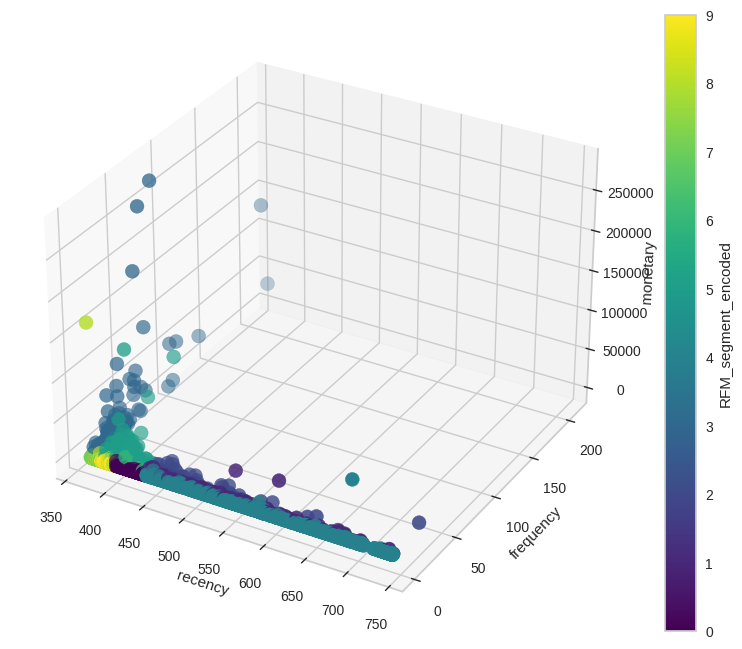

In [ ]:
def plot_3d_scatter(data, x_feature, y_feature, z_feature, target_feature, figsize=(10, 8), cmap='viridis', s=100):
    """
    Generate a 3D scatter plot with color coding by a target variable.

    Parameters:
        data (pd.DataFrame): The dataset to be used.
        x_feature (str): The feature for the x-axis.
        y_feature (str): The feature for the y-axis.
        z_feature (str): The feature for the z-axis.
        target_feature (str): The target variable for color coding.
        figsize (tuple, optional): Figure size (width, height). Default is (10, 8).
        cmap (str, optional): Colormap for color coding. Default is 'viridis'.
        s (int, optional): Marker size. Default is 100.
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with color coding by target variable
    scatter = ax.scatter(data[x_feature], data[y_feature], data[z_feature], c=data[target_feature], cmap=cmap, s=s)

    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.set_zlabel(z_feature)

    # Add colorbar
    plt.colorbar(scatter, label=target_feature)
    plt.legend()
    plt.show()

# plotting cluster on scatterplot
plot_3d_scatter(data_rfm, 'recency', 'frequency', 'monetary', 'RFM_segment_encoded')

##K-means Clustering

In [ ]:
# Extracting 'recency', 'frequency', and 'monetary' columns for KMeans clustering
data_kmeans = data_rfm[['recency', 'frequency', 'monetary']]

# Creating an instance of MinMaxScaler
sc = MinMaxScaler((0, 1))

# Scaling the data
data_kmeans_scaled = sc.fit_transform(data_kmeans)

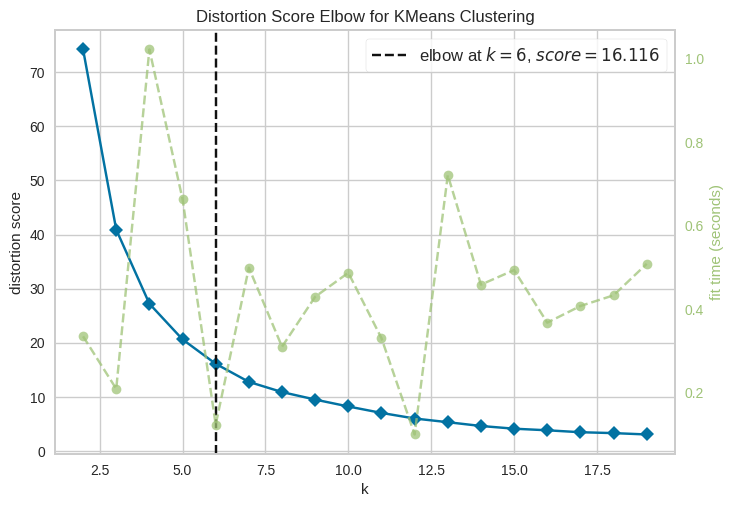

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Creating an instance of KMeans
kmeans = KMeans()

# Creating an instance of KElbowVisualizer
elbow = KElbowVisualizer(kmeans, k=(2, 20))

# Fitting the visualizer to the scaled data
elbow.fit(data_kmeans_scaled)

# Displaying the elbow plot
elbow.show()

In [ ]:
# Getting the optimal k value from the elbow method
optimal_k = elbow.elbow_value_

# Creating an instance of KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k).fit(data_kmeans_scaled)

# Inverse transforming the cluster centers to the original scale
cluster_center = sc.inverse_transform(kmeans.cluster_centers_)
cluster_center = [[round(val, 1) for val in row] for row in cluster_center]

print(cluster_center)

# Assigning cluster labels to each data point
data_kmeans["KMeans_Segment"] = kmeans.labels_

# Displaying the first few rows of the KMeans segmented data
data_kmeans.head()

[[438.4, 2.7, 1059.7], [701.3, 1.4, 651.8], [612.5, 1.5, 592.1], [371.5, 70.2, 88004.0], [524.3, 2.1, 757.7], [383.9, 5.9, 2391.1]]


,recency,frequency,monetary,KMeans_Segment
0,691,1,77183.60,1
1,368,7,4310.00,5
2,441,4,1797.24,0
3,384,1,1757.55,5
4,676,1,334.40,1


In [ ]:
# i have list of list, which each of outer list represent the clusster and inner one represents the co-ordinates of the centroid

# i want to make a dataframe from it,write me a code, cluster as rows and co-ordinates as column

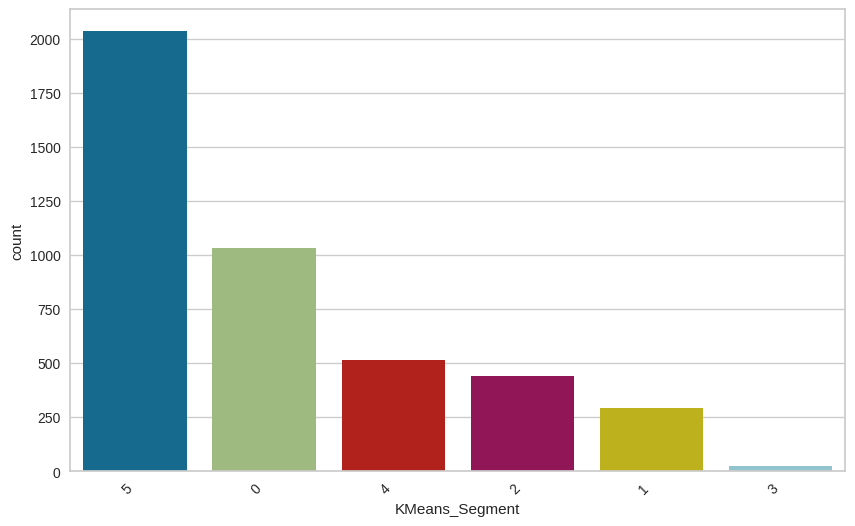

In [ ]:
# Using the countplot function to visualize the distribution of data points in each cluster
countplot(data_kmeans, 'KMeans_Segment')

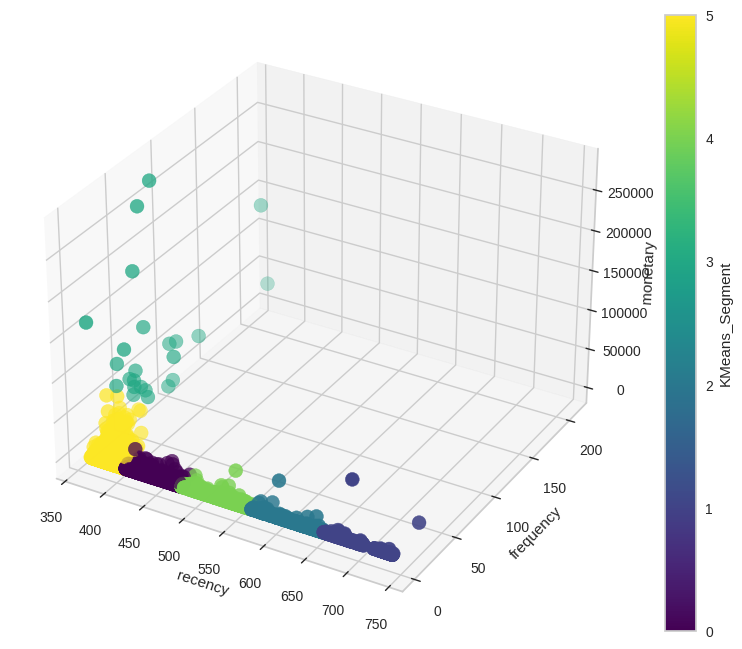

In [ ]:
# Using the plot_3d_scatter function to visualize the KMeans clusters in 3D
plot_3d_scatter(data_kmeans, 'recency', 'frequency', 'monetary', 'KMeans_Segment')

In [ ]:
def groupby_and_describe(data, target_variable, features):
    grouped = data.groupby(target_variable)[features].describe()
    return grouped

# Assuming you have already run the previous code and have 'data_kmeans' DataFrame
summary_stats = groupby_and_describe(data_kmeans, 'KMeans_Segment', ['recency', 'frequency', 'monetary'])

In [ ]:
# Accessing the 'recency' column of the DataFrame 'summary_stats'
# and transposing the result using '.T'
summary_stats.loc[:,'recency'].T

KMeans_Segment,0,1,2,3,4,5
count,1034.000000,293.000000,441.000000,24.000000,512.000000,2034.000000
mean,438.358801,701.310580,612.523810,371.458333,524.324219,383.885447
std,18.833758,27.179183,25.308281,9.016792,25.019843,12.462444
min,411.000000,657.000000,569.000000,366.000000,482.000000,366.000000
25%,423.000000,677.000000,591.000000,367.000000,501.000000,373.000000
50%,436.000000,697.000000,613.000000,368.000000,523.000000,383.000000
75%,451.000000,731.000000,633.000000,371.000000,545.000000,394.000000
max,481.000000,739.000000,656.000000,404.000000,567.000000,412.000000


## Customer Recency Insights

Based on the analysis of different customer groups, we've identified the following insights:

- **Regular Customers (Groups 0, 3, 5):** Customers in these groups, comprising a total of 2,366 individuals, demonstrate consistent and stable purchasing behavior. They show a mean recency ranging from 370 to 440 days, with relatively low standard deviations, indicating a consistent shopping pattern.

- **At-Risk of Churning (Group 4):** This group, consisting of 1,028 individuals, requires special attention. Their mean recency is around 525 days with a slightly higher standard deviation compared to regular customers. This suggests some variability in their purchasing patterns, which could be an early indicator of potential churn.

- **Immediate Attention for Retention (Groups 1, 2):** Customers in these groups, totaling 944 individuals, need immediate attention. They exhibit higher mean recency values of approximately 700 and 612 days respectively, indicating a longer time since their last purchase. This may indicate a decline in engagement and potential risk of churn.

### Suggested Actions

- **Regular Customers (Groups 0, 3, 5):** Continue to provide excellent service and targeted offers to maintain their loyalty and encourage repeat purchases.

- **At-Risk of Churning (Group 4):** Implement a re-engagement strategy, such as personalized promotions or outreach, to prevent potential churn.

- **Immediate Attention for Retention (Groups 1, 2):** Reach out with special offers or incentives to re-engage these customers and bring them back into the active customer base.

Please note that these insights are based on the provided data. Further analysis and customer feedback may be needed to refine these strategies.


In [ ]:
# Accessing the 'frequency' column of the DataFrame 'summary_stats'
# and transposing the result using '.T'
summary_stats.loc[:,'frequency'].T

KMeans_Segment,0,1,2,3,4,5
count,2052.000000,439.000000,1028.000000,290.000000,24.000000,505.000000
mean,5.834308,1.453303,2.694553,1.358621,70.166667,2.126733
std,5.979310,1.045531,2.155604,2.065287,49.312373,1.553216
min,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,45.750000,1.000000
50%,4.000000,1.000000,2.000000,1.000000,56.000000,2.000000
75%,7.000000,2.000000,4.000000,1.000000,87.250000,3.000000
max,55.000000,12.000000,17.000000,34.000000,209.000000,13.000000


## Customer Frequency Insights

Based on the analysis of different customer groups, we've identified the following insights:

- **Highly Frequent (Group 4):** Customers in this group, totaling 24 individuals, are highly active and make purchases frequently. They have a mean frequency of approximately 70 purchases, with a maximum of 200+ purchases for some individuals. This group represents engaged and valuable customers.

- **Moderately Active (Groups 0, 2, 5):** These groups, comprising a total of 3,085 individuals, demonstrate moderate purchasing behavior. They make a mean of around 6 to 2 purchases, with a range of 1 to 17 purchases. While not as frequent as Group 4, they still contribute significantly to the business.

- **Infrequent Shoppers (Groups 1, 3):** Customers in these groups, totaling 728 individuals, make purchases less frequently. They have a mean frequency of around 1 purchases. These groups may require targeted marketing efforts, such as promotions or sales, to increase their engagement.

### Suggested Actions

- **Highly Frequent (Group 4):** Recognize and reward these loyal customers with special offers, loyalty programs, or exclusive access to new products/services.

- **Moderately Active (Groups 0, 2, 5):** Continue to engage and provide value to these customers. Consider personalized recommendations or occasional promotions to encourage repeat purchases.

- **Infrequent Shoppers (Groups 1, 3):** Implement targeted marketing campaigns to re-engage these customers. Highlight promotions, discounts, or unique selling points to encourage more frequent purchases.


In [ ]:
# Accessing the 'monetary' column of the DataFrame 'summary_stats'
# and transposing the result using '.T'
summary_stats.loc[:,'monetary'].T

KMeans_Segment,0,1,2,3,4,5
count,2052.000000,439.000000,1028.000000,290.000000,24.000000,505.000000
mean,2378.528022,596.125811,1059.095498,652.340931,88003.984583,750.420792
std,4053.513363,2242.097467,1367.098981,4538.548182,73408.832919,1914.177348
min,6.900000,12.750000,6.200000,3.750000,11189.910000,15.000000
25%,516.962500,171.100000,328.205000,154.057500,37148.037500,213.700000
50%,1197.345000,310.260000,651.875000,255.235000,59796.865000,416.080000
75%,2634.335000,522.100000,1269.945000,416.987500,119263.355000,781.360000
max,65164.790000,44534.300000,21279.290000,77183.600000,280206.020000,39916.500000


## Customer Spending Insights

Based on the analysis of different customer groups, we've identified the following spending patterns:

- **Highest Spenders (Group 4):** Customers in this group, totaling 24 individuals, are the highest spenders with an average expenditure of approximately 88,000. They represent a valuable segment with significant spending potential.

- **Wise Spenders (Groups 0, 2, 5):** These groups, comprising a total of 3,085 individuals, demonstrate a balanced approach to spending. They have mean expenditures ranging from approximately $2400 to 750. These groups contribute substantially to revenue.

- **Attention Needed (Groups 1, 3):** Customers in these groups, totaling 728 individuals, exhibit lower spending behavior. They have mean expenditures around 600, with some individuals spending as low as 15.00. This segment may require targeted marketing efforts to increase their spending.

### Suggested Actions

- **Highest Spenders (Group 3):** Recognize and reward these high-value customers with exclusive offers, loyalty programs, or premium services to further cultivate their loyalty.

- **Wise Spenders (Groups 0, 2, 4):** Continue to provide value and offer tailored recommendations to these customers. Consider occasional promotions or upselling strategies to maximize their spending potential.

- **Attention Needed (Groups 1, 5):** Implement targeted marketing campaigns to encourage higher spending from these customers. Highlight premium products/services, special promotions, or personalized offers to increase their expenditure.
